In [28]:
pip install bigtree

In [29]:
# installing the required packages
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import pandas as pd
from bigtree import dataframe_to_tree
from scipy.optimize import minimize
from scipy.signal import find_peaks
import matplotlib.pyplot as plt


In [30]:
# Load the Iris dataset
x, y = load_iris(return_X_y=True)

In [31]:
print("x data instance:-", len(x),"\n",x[:5])

x data instance:- 150 
 [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]


In [32]:
print("y is", y)

y is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [33]:
# for Class 0
x0=x[y==0]
y0=y[y==0]

In [34]:
# for Class 1
x1=x[y==1]
y1=y[y==1]

In [35]:
# for Class 2
x2=x[y==2]
y2=y[y==2]

In [36]:
x0[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [37]:
x0.shape

(50, 4)

In [38]:
y0.shape

(50,)

In [39]:
# taking default values as given in the research paper
gmm=0.05
alp=0.5
beta=0.02
nu=0.05
max_depth=4

In [40]:
def all_elements_same(items):
    return len(set(items)) == 1

# bandwidth calculating function
def h_t(dt):
    if(all_elements_same(dt)):
       return 0.9*0.001*((len(dt))**(-0.2))
    dte=dt.copy()
    dte.sort()
    Q1 = np.percentile(dte, 25)
    Q3 = np.percentile(dte, 75)
    IQR = Q3 - Q1
    std_dev = np.std(dte)
    if(float(IQR)!=0.0) :
     return 0.9*(min(std_dev,IQR/1.34))*((len(dte))**(-0.2))
    else :
     return 0.9*std_dev*((len(dte))**(-0.2))

In [41]:
def split_data(dt,k):
  heights = dt.reshape(-1, 1)

  # Create a KDE estimator
  kde = KernelDensity(kernel='gaussian', bandwidth=h_t(dt)).fit(heights)

  # Generate points for density estimation
  x_len = np.linspace(min(heights)-1,max(heights)+1, 1000).reshape(-1, 1)

  # Estimate the density
  log_dens = kde.score_samples(x_len)
  dens = np.exp(log_dens)


  peaks, _ = find_peaks(dens) # peaks contains the maxima points
  minima, _ = find_peaks(-dens) # minima contains the minima points
  dte=dt.copy()
  maxima=peaks.copy()
  dte.sort()
  for i in range(len(minima)):
    peaks=np.append(peaks,minima[i])
  mx_mn=[]
  peaks.sort()
  for i in range(len(peaks)):
    mx_mn.append([peaks[i],dens[peaks[i]]])
  mx_mn=np.array(mx_mn)
  mx=-99999999
  mn=999999999
  new_dte=[]
  for  i in range(len(dte)): # removing data points whose kde values are below gamma * max_peak
    if(np.exp(kde.score_samples([[dte[i]]]))[0]<gmm*max(mx_mn[:,1])):
     continue
    else :
      mx=max(mx,dte[i])
      mn=min(mn,dte[i])
      new_dte.append([dte[i],np.exp(kde.score_samples([[dte[i]]]))[0]])

  # creating a limits array based on condition given in research paper
  limits=[]
  limits.append(mn)
  for i in range(len(peaks)):
    if(i%2==1):
      if(mx_mn[i][1]<=alp*min(mx_mn[i-1][1],mx_mn[i+1][1])):
        limits.append(x_len[int(mx_mn[i][0])][0])
  limits.append(mx)

  splits=[]
  n_dash=len(dt)*(1/(max(dt)-min(dt)))
  impurity=0.0

  # creating splits from limits
  for i in range(1,len(limits)):
    mxx=-99999999.9
    mnn=999999999.9
    n=0
    for j in range(len(new_dte)):
      if(new_dte[j][0]>=limits[i-1] and new_dte[j][0]<=limits[i]):
         mxx=max(mxx,new_dte[j][0])
         mnn=min(mnn,new_dte[j][0])
         n+=1
    if(n<=k):
      continue
    else:
      impurity+=(n*n_dash*(mxx-mnn))/(n+n_dash*(mxx-mnn)) # calculating the impurity
      splits.append([mnn,mxx])
  if(len(splits)==0):
    if(limits[0]==limits[1]):
      return [[]],99999999
    else :
      return [limits],(len(new_dte)*n_dash*(limits[1]-limits[0]))/(len(new_dte)+n_dash*(limits[1]-limits[0]))
  else :
    new_splits = []
    for i in range(len(splits)):
      if(splits[i][0]!=splits[i][1]):
        new_splits.append(splits[i])

    splits = new_splits
    return splits,impurity # returning the splits containing array of (Li, Ri) and the impurity

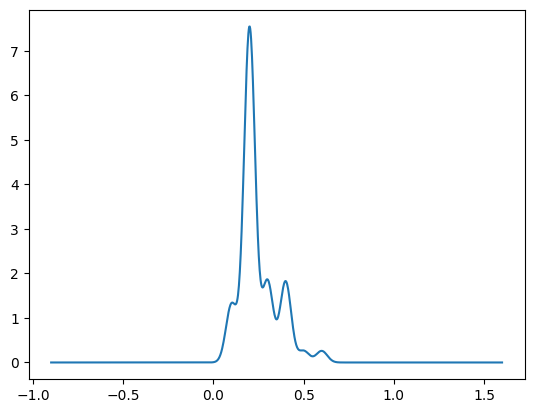

In [42]:
# Plotting the KDE plot for class 0 feature 3 for just checking how the plot looks
x=x0[:,3]
heights = x.reshape(-1, 1)

# Create a KDE estimator
kde = KernelDensity(kernel='gaussian', bandwidth=h_t(x)).fit(heights)

# Generate points for density estimation
x_len = np.linspace(min(heights)-1,max(heights)+1, 1000).reshape(-1, 1)

# Estimate the density
log_dens = kde.score_samples(x_len)
dens = np.exp(log_dens)
plt.plot(x_len,dens)

In [43]:
def impurity_same(impty):
  item=[]
  for i in impty:
     item.append(impty[i])
  return all_elements_same(item)

In [44]:
def check_sl(s): # checks the depth of the oc tree
  c=0
  for i in range(len(s)):
    if(s[i]=="/"):
      c+=1
  return c

In [45]:
dft = pd.DataFrame( [],columns=["PATH","ATR","LR"]) # creating a dataframe which will be converted into oc Tree

# taking 2 d array of data and variables for storing paths for future work of OC Tree ( fcc )
def fit(data,fcc,k,s,dft):
 data = np.array(data) if isinstance(data, list) else data

 if(fcc==0):
  dft.loc[len(dft.index)] =[s, None,None]
  fit(data,fcc+1,k,s,dft)
 else :
  if(fcc!=1):
    if(  check_sl(dft.iloc[len(dft.index)-1]['PATH'])>=max_depth): # local  and global Stopping Conditions
     return
    else:
      dict={}
      impurity={}
      for j in range(len(data[0])):
        dict[j],impurity[j]=split_data(data[:,j],k) # calculating splits and impurity for each feature
      mn=9999999
      key=0
      if(impurity_same(impurity)): # taking best feature for splits based on impurity
         c=check_sl(dft.iloc[len(dft.index)-1]['PATH'])
         arr={}
         atr_min_cnt=99999
         for j in range(len(data[0])):
          arr[j]=0
         for i in range(len(dft.index)-1,len(dft.index)-1-c,-1):
           arr[(dft.iloc[i]['ATR'])]+=1
         for j in arr:
           if(arr[j]<atr_min_cnt):
            atr_min_cnt=arr[j]
            key=j

      else :
       for j in impurity:
            if(impurity[j]<mn):
              mn=impurity[j]
              key=j
      split=dict[key]
      dte =[]
      for i in range(len(split)):
        chi=[]
        for j in range(len(data)):
          if( data[j][key]>=split[i][0] and data[j][key]<=split[i][1]):
               chi.append(data[j])
        dte.append(chi)
      for i in range(len(dte)):
        s+='/'+str(fcc)
        val = split[i]

        dft.loc[len(dft.index)] = [s,key,val] # storing path , feature, splits limit

        fit(dte[i],fcc+1,k,s,dft) # making the Recursive Call for the next node
        s=s[:-2]

  else :
      dict={}
      impurity={}
      for j in range(len(data[0])):
        dict[j],impurity[j]=split_data(data[:,j],k)
      mn=9999999
      key=0

      for j in impurity:
          if(impurity[j]<mn):
            mn=impurity[j]
            key=j
      split=m=np.array(dict[(key)])

      dte =[]

      for i in range(len(split)):
        chi=[]
        for j in range(len(data)):
          if( data[j][key]>=split[i][0] and data[j][key]<=split[i][1]):
               chi.append(data[j])
        dte.append(chi)


      for i in range(len(dte)):
        s+='/'+str(fcc)
        val = split[i]

        dft.loc[len(dft.index)] = [s,key,val]
        fit(dte[i],fcc+1,k,s,dft)
        s=s[:-2]


In [46]:
fit(x0,0,int(beta*len(x0)),'0',dft) # storing the oc Tree into dataframe

In [47]:
print(dft)

        PATH   ATR          LR
0          0  None        None
1        0/1     3  [0.1, 0.4]
2      0/1/2     1  [2.9, 4.4]
3    0/1/2/3     2  [1.0, 1.7]
4  0/1/2/3/4     0  [4.3, 5.8]


In [48]:
# Converting dataframe to Tree
rooot = dataframe_to_tree(dft)
rooot.show(attr_list=["PATH","ATR","LR"])

0 [ATR=None, LR=None]
└── 1 [ATR=3, LR=[0.1 0.4]]
    └── 2 [ATR=1, LR=[2.9, 4.4]]
        └── 3 [ATR=2, LR=[1.0, 1.7]]
            └── 4 [ATR=0, LR=[4.3, 5.8]]


In [49]:
# function for prediction of class given 1d array
def pred(node,dt):
    for child in node.children:
      if(dt[child.ATR]>=child.LR[0] and dt[child.ATR]<=child.LR[1] ):
        pred(child,dt)
        if child.children != ():
            if(pred(child,dt)):
               return "Yes"
        else :
            return "Yes"
      else :
        continue
    return "No"


In [50]:
dt=x0[2]

In [51]:
dt

array([4.7, 3.2, 1.3, 0.2])

# comparing results with the svdd method

In [52]:
pip install deep-svdd  # Example, adjust based on actual package/library


  Using cached deep_svdd-1.3-py3-none-any.whl (5.2 kB)
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


# Conducting Experiments

## Using Approach A :- where we are deviding our dataset into training and test dataset with training as 90% of the data while testing as the 10%of the data. this has been done due to lower number of instances availiable for a particular class in our IRIS dataset

### For Class 0

In [53]:
from sklearn.metrics import precision_score, recall_score
from sklearn.svm import OneClassSVM  # Assuming SVDD is similar to sklearn's OneClassSVM for demonstration

dft0 = pd.DataFrame( [],columns=["PATH","ATR","LR"])

# Split the data into training and testing sets
X_train, X_test = train_test_split(x0, test_size=0.1, random_state=2)

fit(X_train,0,int(beta*len(X_train)),'0',dft0)
rooot0 = dataframe_to_tree(dft0)
rooot0.show(attr_list=["PATH","ATR","LR"])

# Train SVDD
svdd_model = OneClassSVM(kernel='rbf', nu=0.1)  # Nu parameter determines the ratio of outliers
svdd_model.fit(X_train)

# Predictions for SVDD
svdd_predictions = svdd_model.predict(X_test)  # SVDD predicts 1 for inliers and -1 for outliers

# Convert SVDD predictions to match Simple OC Tree format (1 for target class, -1 for outliers)
svdd_predictions = np.where(svdd_predictions == 1, 1, -1)

pred_arr = []
for i in range(len(X_test)):
  if(pred(rooot0, X_test[i]) == "Yes"):
    pred_arr.append(1)
  else:
    pred_arr.append(-1)

# Calculate precision and recall for both models
oc_tree_precision = precision_score(y_true=np.ones(len(X_test)), y_pred=pred_arr)
oc_tree_recall = recall_score(y_true=np.ones(len(X_test)), y_pred=pred_arr)

f1_score_oc_tree = 2*(oc_tree_precision * oc_tree_recall)/ ( oc_tree_precision + oc_tree_recall)

svdd_precision = precision_score(y_true=np.ones(len(X_test)), y_pred=svdd_predictions)
svdd_recall = recall_score(y_true=np.ones(len(X_test)), y_pred=svdd_predictions)

f1_score_svdd = 2*(svdd_precision * svdd_recall)/ ( svdd_precision + svdd_recall)


print("OC Tree Precision:", oc_tree_precision)
print("OC Tree Recall:", oc_tree_recall)
print("OC Tree F1 Score:", f1_score_oc_tree)
print("SVDD Precision:", svdd_precision)
print("SVDD Recall:", svdd_recall)
print("SVDD F1 Score:", f1_score_svdd)
plt.tight_layout()
plt.show()


0 [ATR=None, LR=None]
└── 1 [ATR=3, LR=[0.1 0.4]]
    └── 2 [ATR=2, LR=[1.2, 1.7]]
        └── 3 [ATR=0, LR=[4.4, 5.8]]
            └── 4 [ATR=0, LR=[4.4, 5.8]]
OC Tree Precision: 1.0
OC Tree Recall: 1.0
OC Tree F1 Score: 1.0
SVDD Precision: 1.0
SVDD Recall: 0.8
SVDD F1 Score: 0.888888888888889


<Figure size 640x480 with 0 Axes>

## Using Approach B:- where we are taking another classes data as our outlier and testing our model based on it on predicting the outlier

#### For Class 0 with class 2 data as outliers in the test data

In [54]:
from sklearn.metrics import precision_score, recall_score
from sklearn.svm import OneClassSVM  # Assuming SVDD is similar to sklearn's OneClassSVM for demonstration

dft0 = pd.DataFrame( [],columns=["PATH","ATR","LR"])

# Split the data into training and testing sets
_, X_test_target = train_test_split(x0, test_size=0.2, random_state=42)
X_train = x0

# Similarly, take a portion of x2 to use as outliers in the test set
_, X_test_outliers = train_test_split(x1, test_size=0.2, random_state=42)

# Combine the target part and the outlier part to form the new test set
X_test = np.concatenate((X_test_target, X_test_outliers), axis=0)


fit(X_train,0,int(beta*len(X_train)),'0',dft0)
rooot0 = dataframe_to_tree(dft0)
rooot0.show(attr_list=["PATH","ATR","LR"])

# Train SVDD
svdd_model = OneClassSVM(kernel='rbf', nu=0.1)  # Nu parameter determines the ratio of outliers
svdd_model.fit(X_train)

# Predictions for SVDD
svdd_predictions = svdd_model.predict(X_test)  # SVDD predicts 1 for inliers and -1 for outliers

# Convert SVDD predictions to match Simple OC Tree format (1 for target class, -1 for outliers)
svdd_predictions = np.where(svdd_predictions == 1, 1, -1)

pred_arr = []
for i in range(len(X_test)):
  if(pred(rooot0, X_test[i]) == "Yes"):
    pred_arr.append(1)
  else:
    pred_arr.append(-1)


# Use floor division to ensure the argument is an integer
array_true_val = [np.ones(len(X_test) // 2), np.ones(len(X_test) - (len(X_test) // 2)) * -1]
array_true_val = np.concatenate(array_true_val)

# Calculate precision and recall for both models
oc_tree_precision = precision_score(y_true=array_true_val, y_pred=pred_arr)
oc_tree_recall = recall_score(y_true=array_true_val, y_pred=pred_arr)

f1_score_oc_tree = 2*(oc_tree_precision * oc_tree_recall)/ ( oc_tree_precision + oc_tree_recall)

svdd_precision = precision_score(y_true=array_true_val, y_pred=svdd_predictions)
svdd_recall = recall_score(y_true=array_true_val, y_pred=svdd_predictions)

f1_score_svdd = 2*(svdd_precision * svdd_recall)/ ( svdd_precision + svdd_recall)


print("OC Tree Precision:", oc_tree_precision)
print("OC Tree Recall:", oc_tree_recall)
print("OC Tree F1 Score:", f1_score_oc_tree)
print("SVDD Precision:", svdd_precision)
print("SVDD Recall:", svdd_recall)
print("SVDD F1 Score:", f1_score_svdd)
plt.tight_layout()
plt.show()


0 [ATR=None, LR=None]
└── 1 [ATR=3, LR=[0.1 0.4]]
    └── 2 [ATR=1, LR=[2.9, 4.4]]
        └── 3 [ATR=2, LR=[1.0, 1.7]]
            └── 4 [ATR=0, LR=[4.3, 5.8]]
OC Tree Precision: 1.0
OC Tree Recall: 1.0
OC Tree F1 Score: 1.0
SVDD Precision: 1.0
SVDD Recall: 0.9
SVDD F1 Score: 0.9473684210526316


<Figure size 640x480 with 0 Axes>